# DEMETER2 in Stan

In [1]:
import pystan
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import arviz as az
from pathlib import Path
import seaborn as sns
from timeit import default_timer as timer
import warnings
import re

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15

modeling_data_dir = Path('../modeling_data')

warnings.filterwarnings(action='ignore', 
                        message='Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won\'t be used')

## Data preparation

In [2]:
modeling_data = pd.read_csv(modeling_data_dir / 'subset_modeling_data.csv')
modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol
0,ACAGAAGAAATTCTGGCAGAT,ln215_central_nervous_system,1.966515,1,EIF6
1,ACAGAAGAAATTCTGGCAGAT,ln382_central_nervous_system,1.289606,1,EIF6
2,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6
3,ACAGAAGAAATTCTGGCAGAT,jhesoad1_oesophagus,1.392272,1,EIF6
4,ACAGAAGAAATTCTGGCAGAT,km12_large_intestine,0.820838,1,EIF6


## Exploratory data analysis

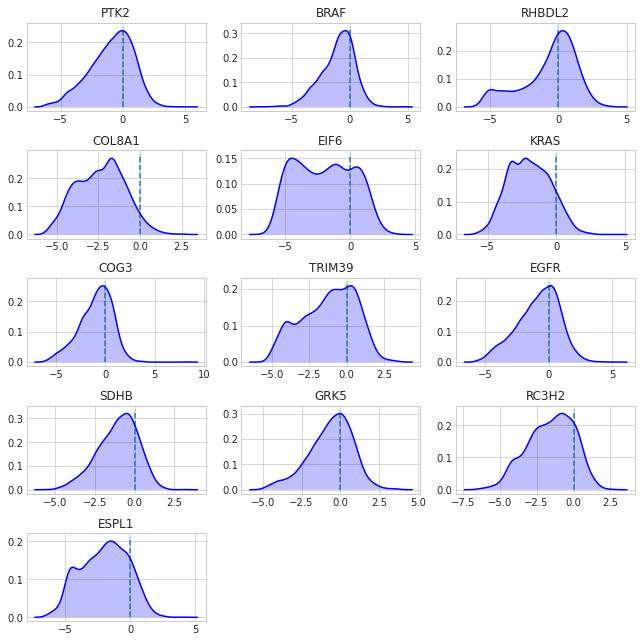

In [3]:
genes = set(modeling_data.gene_symbol.to_list())
fig, axes = plt.subplots(5, 3, figsize=(9, 9))
for ax, gene in zip(axes.flat, genes):
    lfc = modeling_data[modeling_data.gene_symbol == gene].lfc
    sns.distplot(lfc, kde=True, hist=False, ax=ax, kde_kws={'shade': True}, color='b')
    
    y_data = ax.lines[0].get_ydata()
    ax.vlines(x=0, ymin=0, ymax=np.max(y_data) * 1.05, linestyles='dashed')
    
    ax.set_title(gene, fontsize=12)
    ax.set_xlabel(None)


axes[4, 2].axis('off')
axes[4, 1].axis('off')
fig.tight_layout(pad=1.0)
plt.show()

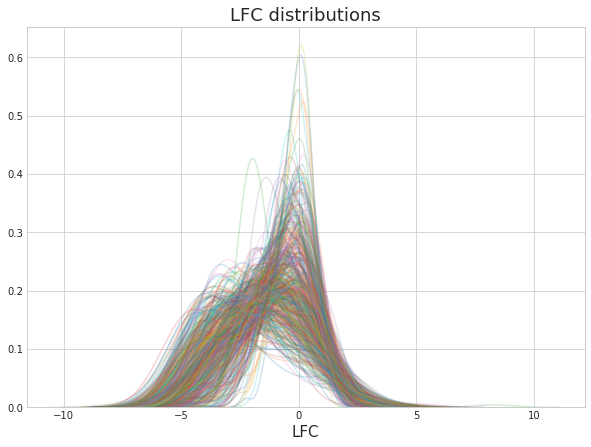

In [4]:
cell_lines = set(modeling_data.cell_line.to_list())
for cell_line in cell_lines:
    lfc = modeling_data[modeling_data.cell_line == cell_line].lfc
    sns.distplot(lfc, kde=True, hist=False, label=None, kde_kws={'alpha': 0.2})

plt.title('LFC distributions')
plt.xlabel('LFC')
plt.show()

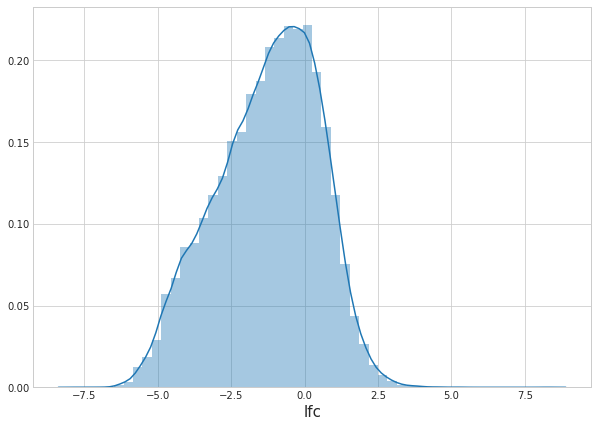

In [5]:
sns.distplot(modeling_data.lfc)
plt.show()

In [6]:
modeling_data[['barcode_sequence', 'gene_symbol']].drop_duplicates().groupby('gene_symbol').count()

,barcode_sequence
gene_symbol,
BRAF,8
COG3,5
COL8A1,5
EGFR,19
EIF6,5
ESPL1,5
GRK5,5
KRAS,11
PTK2,23


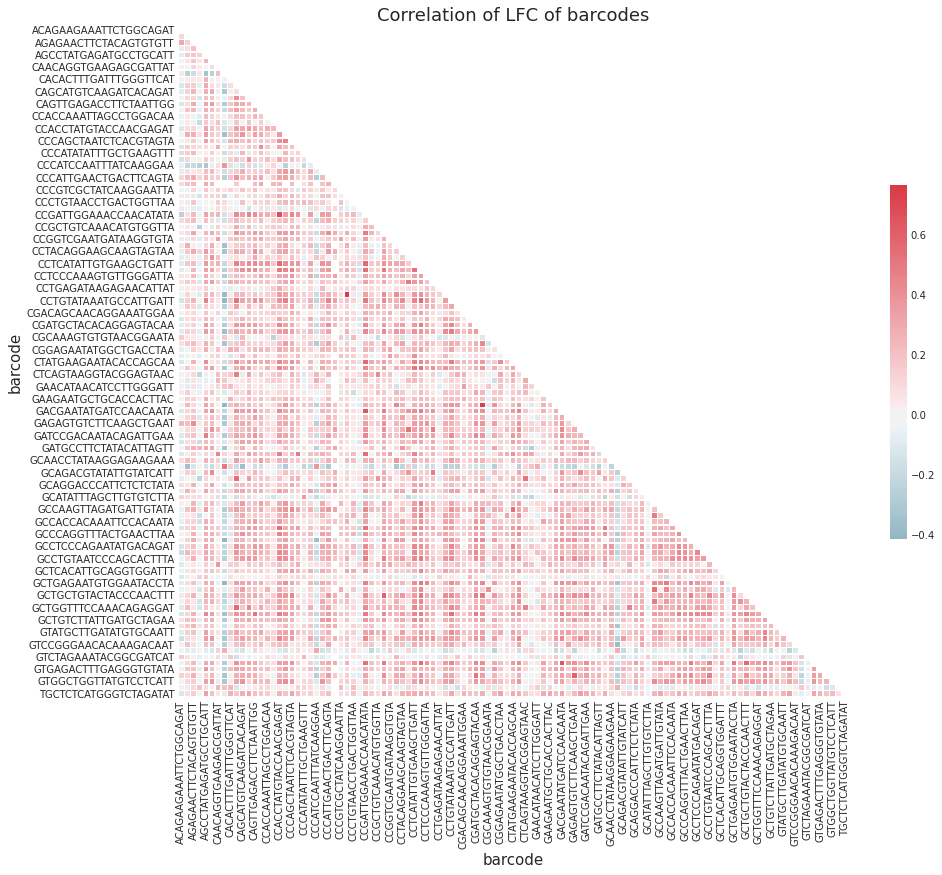

In [7]:
lfc_corr = modeling_data \
    .pivot(index='cell_line', columns='barcode_sequence', values='lfc') \
    .corr()

mask = np.triu(np.ones_like(lfc_corr, dtype=np.bool), k=0)
f, ax = plt.subplots(figsize=(15, 13))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(lfc_corr, mask=mask, 
            cmap=cmap, center=0, 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
plt.xlabel('barcode')
plt.ylabel('barcode')
plt.title('Correlation of LFC of barcodes')
plt.show()

## Modeling

In [8]:
models_dir = Path('..', 'models')

In [9]:
modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol
0,ACAGAAGAAATTCTGGCAGAT,ln215_central_nervous_system,1.966515,1,EIF6
1,ACAGAAGAAATTCTGGCAGAT,ln382_central_nervous_system,1.289606,1,EIF6
2,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6
3,ACAGAAGAAATTCTGGCAGAT,jhesoad1_oesophagus,1.392272,1,EIF6
4,ACAGAAGAAATTCTGGCAGAT,km12_large_intestine,0.820838,1,EIF6


Select only a few cell lines while model building.

In [10]:
len(np.unique(modeling_data.cell_line))

501

In [11]:
np.random.seed(123)
cell_lines = np.random.choice(np.unique(modeling_data.cell_line), 40)
modeling_data = modeling_data[modeling_data.cell_line.isin(cell_lines)]
modeling_data.shape

(3334, 5)

In [12]:
np.unique(modeling_data.gene_symbol)

array(['BRAF', 'COG3', 'COL8A1', 'EGFR', 'EIF6', 'ESPL1', 'GRK5', 'KRAS',
       'PTK2', 'RC3H2', 'RHBDL2', 'SDHB', 'TRIM39'], dtype=object)

In [13]:
model_testing_genes = ['COG3', 'KRAS', 'COL8A1', 'EIF6']
modeling_data = modeling_data[modeling_data.gene_symbol.isin(model_testing_genes)]

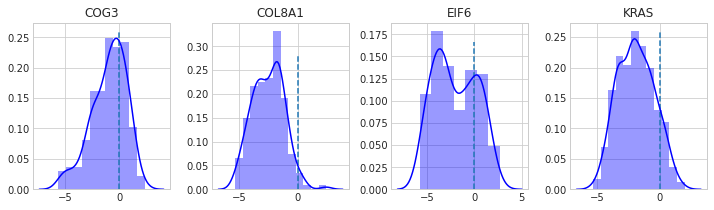

In [14]:
genes = set(modeling_data.gene_symbol.to_list())
fig, axes = plt.subplots(1, 4, figsize=(10, 3))
for ax, gene in zip(axes.flat, genes):
    lfc = modeling_data[modeling_data.gene_symbol == gene].lfc
    sns.distplot(lfc, kde=True, hist=True, ax=ax, color='b')
    
    y_data = ax.lines[0].get_ydata()
    ax.vlines(x=0, ymin=0, ymax=np.max(y_data) * 1.05, linestyles='dashed')
    
    ax.set_title(gene, fontsize=12)
    ax.set_xlabel(None)

fig.tight_layout(pad=1.0)
plt.show()

In [15]:
def add_categorical_idx(df, col):
    df[f'{col}_idx'] = df[col].astype('category').cat.codes + 1
    return df

for col in ['barcode_sequence', 'cell_line', 'gene_symbol']:
    modeling_data = add_categorical_idx(modeling_data, col)

modeling_data = modeling_data.reset_index(drop=True)
modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol,barcode_sequence_idx,cell_line_idx,gene_symbol_idx
0,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6,1,11,3
1,ACAGAAGAAATTCTGGCAGAT,dbtrg05mg_central_nervous_system,2.145082,2,EIF6,1,9,3
2,ACAGAAGAAATTCTGGCAGAT,bt20_breast,0.932751,2,EIF6,1,3,3
3,ACAGAAGAAATTCTGGCAGAT,sw1783_central_nervous_system,1.372030,2,EIF6,1,36,3
4,ACAGAAGAAATTCTGGCAGAT,kns60_central_nervous_system,0.803835,2,EIF6,1,18,3


Binary matrix of $[shRNA \times gene]$.

In [16]:
shrna_gene_matrix = modeling_data[['barcode_sequence_idx', 'gene_symbol_idx']] \
    .drop_duplicates() \
    .reset_index(drop=True) \
    .assign(value = lambda df: np.ones(df.shape[0], dtype=int)) \
    .pivot(index='barcode_sequence_idx', columns='gene_symbol_idx', values='value') \
    .fillna(0) \
    .to_numpy() \
    .astype(int)

shrna_gene_matrix

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

In [17]:
shrna_gene_matrix.shape

(26, 4)

## Model 1. Just an intercept

$$
D \sim N(\mu, \sigma) \\
\mu = \alpha \\
\alpha \sim N(0, 5) \\
\sigma \sim \text{HalfCauchy}(0, 5)
$$

**Model data.**

In [18]:
d2_m1_data = {
    'N': int(modeling_data.shape[0]),
    'y': modeling_data.lfc
}

**Compile model.**

In [19]:
start = timer()
d2_m1_file = models_dir / 'd2_m1.cpp'
d2_m1 = pystan.StanModel(file=d2_m1_file.as_posix())
end = timer()
print(f'{(end - start) / 60:.2f} minutes to compile model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2a3da92f7ba3e62805394cf29daed746 NOW.


0.74 minutes to compile model


In [20]:
d2_m1_fit = d2_m1.sampling(data=d2_m1_data, iter=2000, chains=2)

In [21]:
pystan.check_hmc_diagnostics(d2_m1_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [22]:
az_d2_m1 = az.from_pystan(posterior=d2_m1_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m1)
az.summary(az_d2_m1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-1.855,0.055,-1.957,-1.751,0.001,0.001,2097.0,2092.0,2084.0,1201.0,1.0
sigma,1.713,0.039,1.641,1.790,0.001,0.001,1533.0,1533.0,1540.0,1179.0,1.0


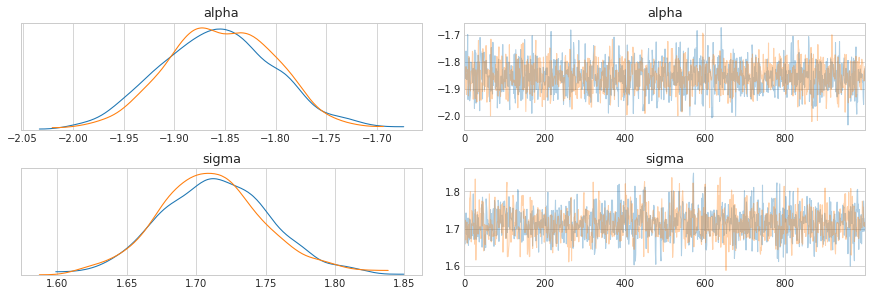

In [23]:
az.plot_trace(az_d2_m1)
plt.show()

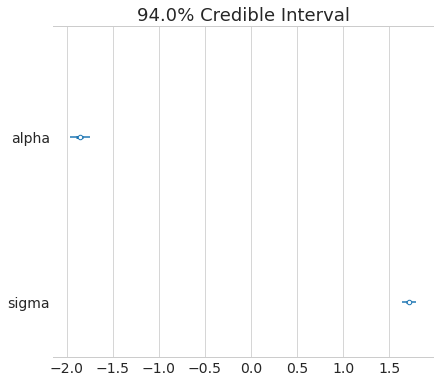

In [24]:
az.plot_forest(az_d2_m1, combined=True)
plt.show()

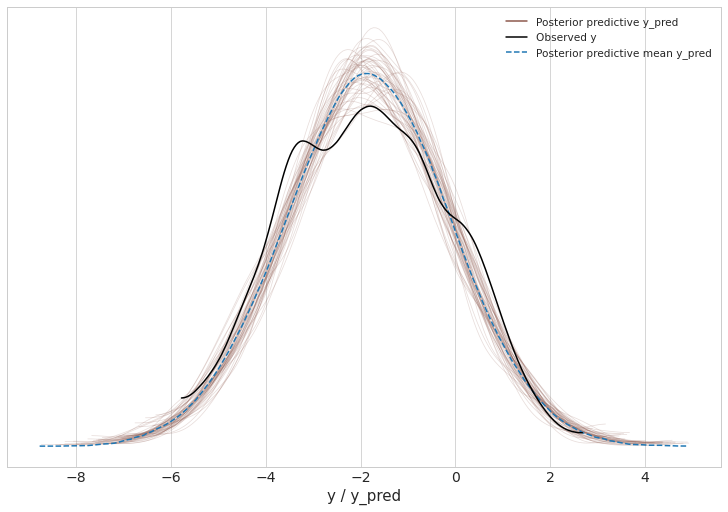

In [25]:
az.plot_ppc(az_d2_m1, data_pairs={'y':'y_pred'}, num_pp_samples=50)
plt.show()

## Model 2. Varying intercept by shRNA

$$
D_{i|s} \sim N(\mu_{i|s}, \sigma) \\
\mu = \alpha_{i|s} \\
\alpha \sim N(\mu_{\alpha}, \sigma_{\alpha}) \\
\mu_{\alpha} \sim N(0, 2) \\
\sigma_{\alpha} \sim \text{HalfCauchy}(0, 2) \\
\sigma \sim \text{HalfCauchy}(0, 5)
$$

### Generative model for a prior predictive check

In [26]:
N = 1000
S = 100
shrna_barcodes = list(range(1, S+1))
shrna_barcodes_idx = np.repeat(shrna_barcodes, N/S)

In [27]:
d2_m2_gen_data = {
    'N': N,
    'S': S,
    'shrna': shrna_barcodes_idx
}

In [28]:
start = timer()
d2_m2_gen_file = models_dir / 'd2_m2_generative.cpp'
d2_m2_gen = pystan.StanModel(file=d2_m2_gen_file.as_posix())
end = timer()
print(f'{(end - start) / 60:.2f} minutes to compile model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_112516ecd402d13dafa0de6e631a9e45 NOW.


0.67 minutes to compile model


In [29]:
d2_m2_gen_fit = d2_m2_gen.sampling(data=d2_m2_gen_data, iter=10, chains=1, algorithm='Fixed_param')

In [30]:
az_d2_m2_gen = az.from_pystan(d2_m2_gen_fit)

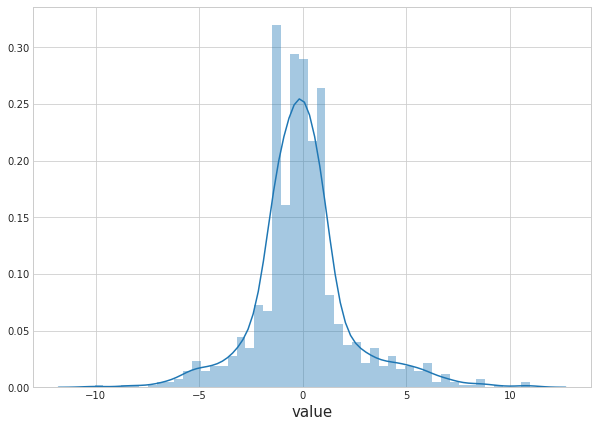

In [31]:
df = d2_m2_gen_fit.to_dataframe() \
    .drop(['chain', 'draw', 'warmup'], axis=1) \
    .melt(var_name='parameter', value_name='value')
df = df[df.parameter.str.contains('alpha\[')]
sns.distplot(df.value)
plt.show()

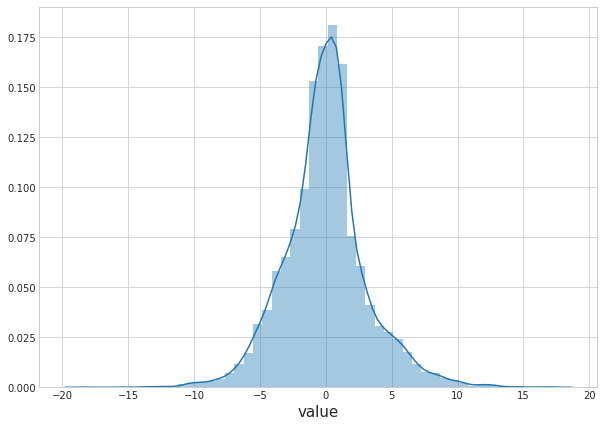

In [32]:
df = d2_m2_gen_fit.to_dataframe() \
    .drop(['chain', 'draw', 'warmup'], axis=1) \
    .melt(var_name='parameter', value_name='value')
df = df[df.parameter.str.contains('y_pred')]
sns.distplot(df.value)
plt.show()

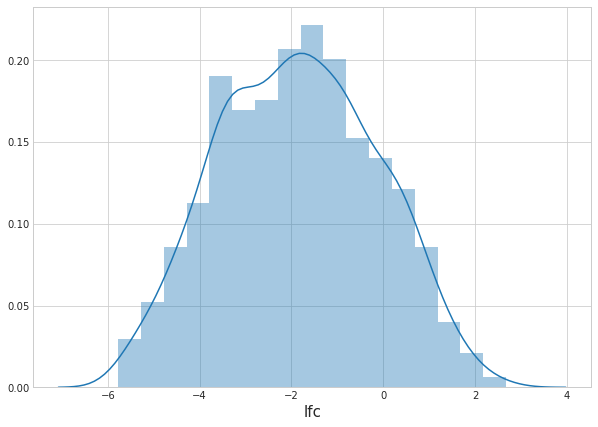

In [33]:
sns.distplot(modeling_data.lfc)
plt.show()

**Model data**

In [34]:
d2_m2_data = {
    'N': int(modeling_data.shape[0]),
    'S': np.max(modeling_data.barcode_sequence_idx),
    
    'shrna': modeling_data.barcode_sequence_idx,
    
    'y': modeling_data.lfc,
}

In [35]:
d2_m2_data['S']

26

**Compile model.**

The current problem is that the various values for `alpha` of different shRNA are the same because `sigma_alpha` is so small.
Maybe try with just two shRNA, but I need to figure out why the value for `sigma_alpha` is shrinking so fast.

In [36]:
start = timer()
d2_m2_file = models_dir / 'd2_m2.cpp'
d2_m2 = pystan.StanModel(file=d2_m2_file.as_posix())
end = timer()
print(f'{(end - start) / 60:.2f} minutes to compile model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_27c69fe8813455b868fbd0406f6b51bd NOW.


0.72 minutes to compile model


In [37]:
d2_m2_fit = d2_m2.sampling(data=d2_m2_data, iter=1000, chains=2)

In [38]:
pystan.check_hmc_diagnostics(d2_m2_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [39]:
az_d2_m2 = az.from_pystan(posterior=d2_m2_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m2)
az.summary(az_d2_m2).head()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha,-1.826,0.248,-2.291,-1.370,0.006,0.004,1945.0,1945.0,1929.0,800.0,1.00
sigma_alpha,1.249,0.194,0.927,1.631,0.005,0.004,1577.0,1394.0,1849.0,795.0,1.01
alpha[0],0.703,0.209,0.295,1.072,0.004,0.003,2354.0,2056.0,2387.0,738.0,1.00
alpha[1],-0.800,0.220,-1.259,-0.430,0.004,0.003,2638.0,2025.0,2585.0,666.0,1.01
alpha[2],-2.268,0.201,-2.637,-1.899,0.005,0.003,1741.0,1688.0,1718.0,862.0,1.00


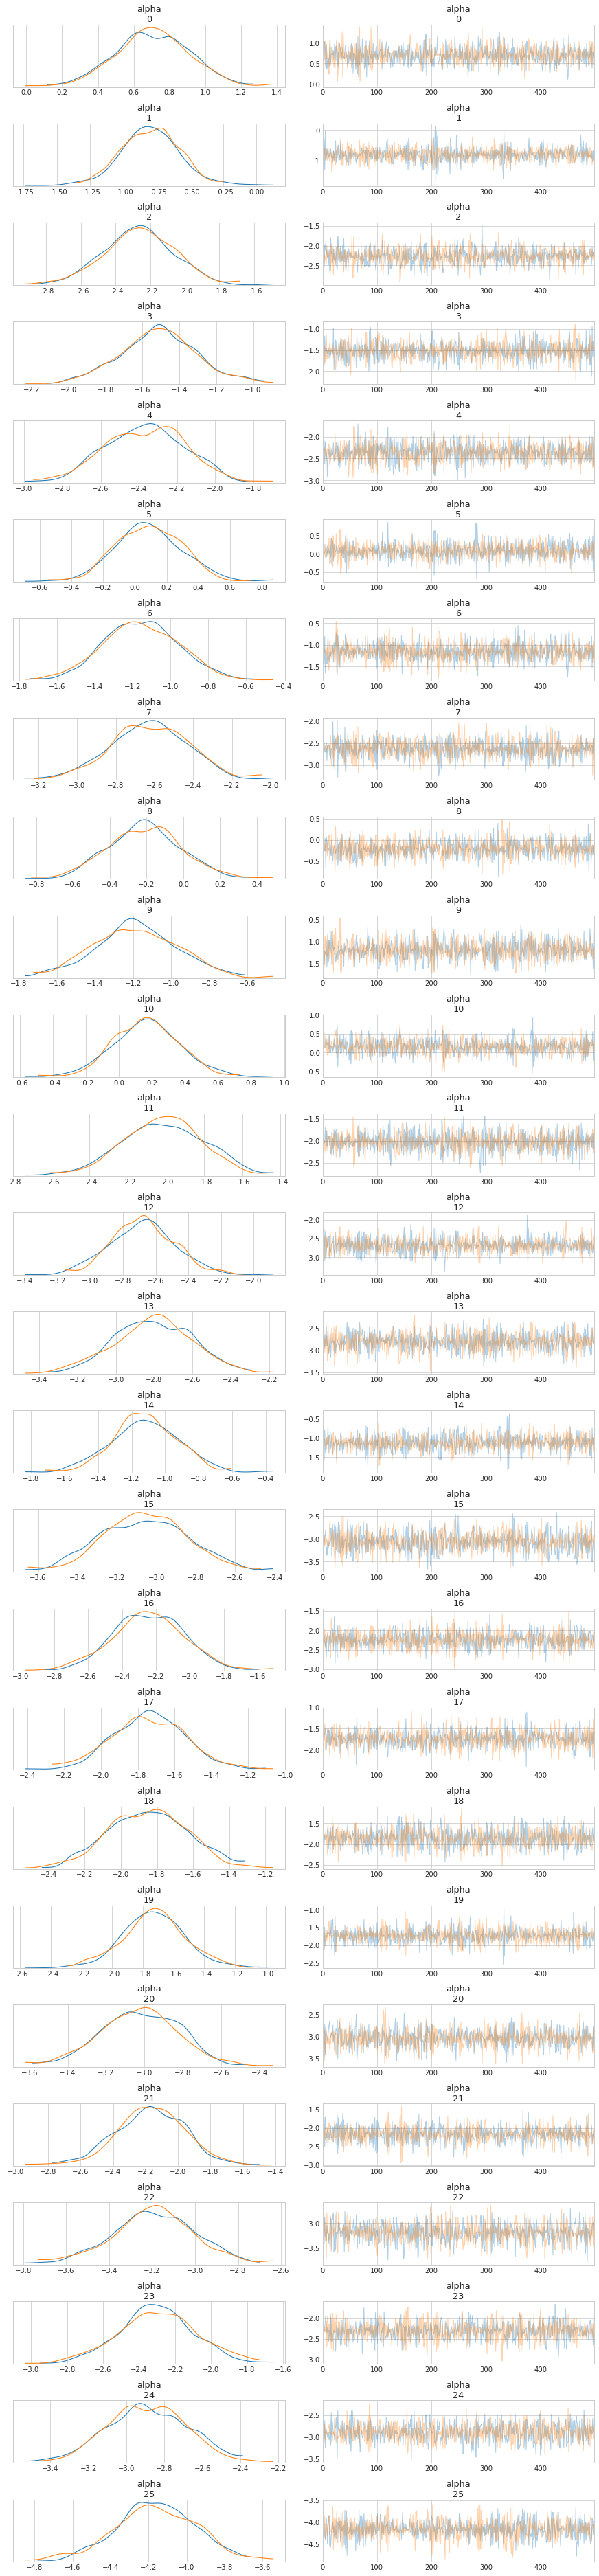

In [40]:
az.plot_trace(az_d2_m2, var_names=['alpha'])
plt.show()

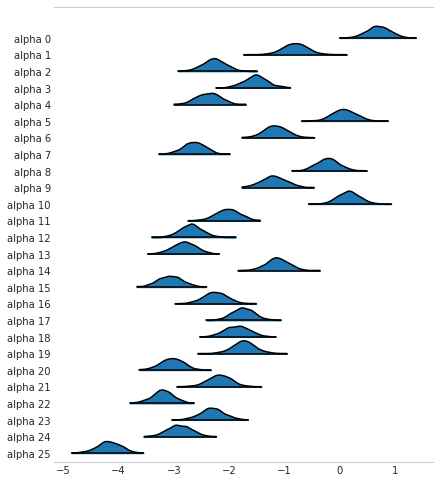

In [41]:
az.plot_forest(az_d2_m2, kind='ridgeplot', combined=True, var_names=['alpha'])
plt.show()

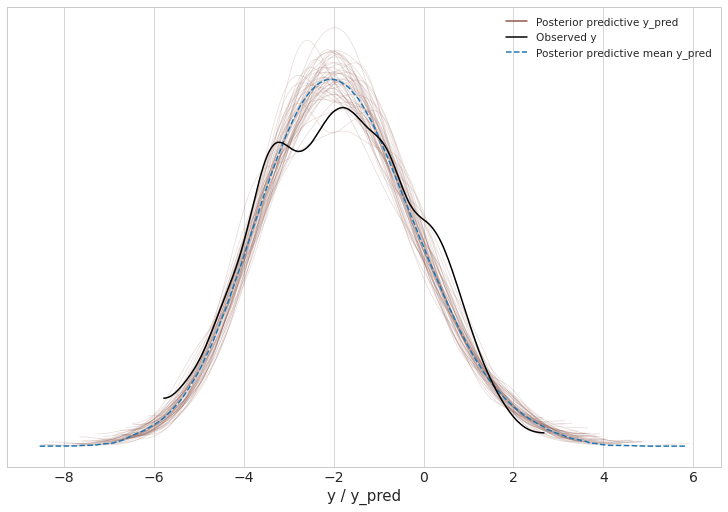

In [42]:
az.plot_ppc(az_d2_m2, data_pairs={'y':'y_pred'}, num_pp_samples=50)
plt.show()

In [43]:
d2_m2_fit.to_dataframe().head()

,chain,draw,warmup,mu_alpha,sigma_alpha,alpha[1],alpha[2],alpha[3],alpha[4],alpha[5],...,y_pred[960],y_pred[961],y_pred[962],lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,-1.717343,1.153475,0.768823,-0.517442,-1.839851,-1.309714,-2.768498,...,-3.806916,-5.609710,-3.315077,-723.551342,0.808957,0.554071,3,7,0,739.722806
1,0,1,0,-1.667439,1.467565,0.805954,-1.191569,-2.040256,-1.101814,-2.732943,...,-4.549657,-4.526206,-3.209196,-727.934890,0.815801,0.554071,3,7,0,742.966630
2,0,2,0,-1.649163,1.431593,0.872164,-1.353188,-1.990979,-1.180292,-2.622750,...,-4.853599,-3.584805,-6.296632,-730.323014,0.980871,0.554071,3,7,0,742.993687
3,0,3,0,-2.053052,1.165102,0.577352,-0.302050,-2.542299,-1.870215,-2.097786,...,-4.024895,-3.423712,-3.636841,-730.812147,0.960364,0.554071,3,7,0,750.384967
4,0,4,0,-1.603363,1.230839,1.026905,-1.301742,-1.983990,-1.168913,-2.630462,...,-3.843858,-4.776930,-2.566063,-727.492163,1.000000,0.554071,3,7,0,744.349184


## Model 3. Another varying intercept for target gene

$$
D_{i|s} \sim N(\mu_{i|s}, \sigma) \\
\mu = \alpha_{i|s} + g_{i|l}\\
\alpha_s \sim N(\mu_{\alpha}, \sigma_{\alpha}) \\
g_l \sim N(\mu_g, \sigma_g) \\
\mu_{\alpha} \sim N(0, 2) \quad \sigma_{\alpha} \sim \text{HalfCauchy}(0, 10) \\
\mu_{g} \sim N(0, 2) \quad \sigma_{g} \sim \text{HalfCauchy}(0, 10) \\
\sigma \sim \text{HalfCauchy}(0, 10)
$$

In [44]:
d2_m3_data = {
    'N': int(modeling_data.shape[0]),
    'S': np.max(modeling_data.barcode_sequence_idx),
    'L': np.max(modeling_data.gene_symbol_idx),
    
    'shrna': modeling_data.barcode_sequence_idx,
    'gene': modeling_data.gene_symbol_idx,
    
    'y': modeling_data.lfc,
}

**Compile model.**

In [45]:
start = timer()
d2_m3_file = models_dir / 'd2_m3.cpp'
d2_m3 = pystan.StanModel(file=d2_m3_file.as_posix())
end = timer()
print(f'{(end - start) / 60:.2f} minutes to compile model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_85af818ae9105b1cf51943262fb26a36 NOW.


0.75 minutes to compile model


In [46]:
d2_m3_control = {'adapt_delta': 0.999, 
                 'max_treedepth': 20}
d2_m3_fit = d2_m3.sampling(data=d2_m3_data, 
                           iter=3000, warmup=1000, chains=4, 
                           control=d2_m3_control)

In [47]:
pystan.check_hmc_diagnostics(d2_m3_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': False,
 'treedepth': True,
 'energy': True}

In [48]:
az_d2_m3 = az.from_pystan(posterior=d2_m3_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m3)
az.summary(az_d2_m3).head()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha,-0.940,1.322,-3.404,1.478,0.093,0.066,201.0,201.0,199.0,345.0,1.02
sigma_alpha,1.198,0.186,0.886,1.558,0.006,0.004,1098.0,1098.0,1002.0,1730.0,1.00
mu_g,-0.838,1.315,-3.236,1.647,0.088,0.063,221.0,221.0,220.0,383.0,1.02
sigma_g,0.853,1.050,0.014,2.259,0.038,0.027,773.0,773.0,342.0,332.0,1.00
alpha[0],1.649,1.368,-0.849,4.215,0.096,0.068,205.0,205.0,204.0,382.0,1.02


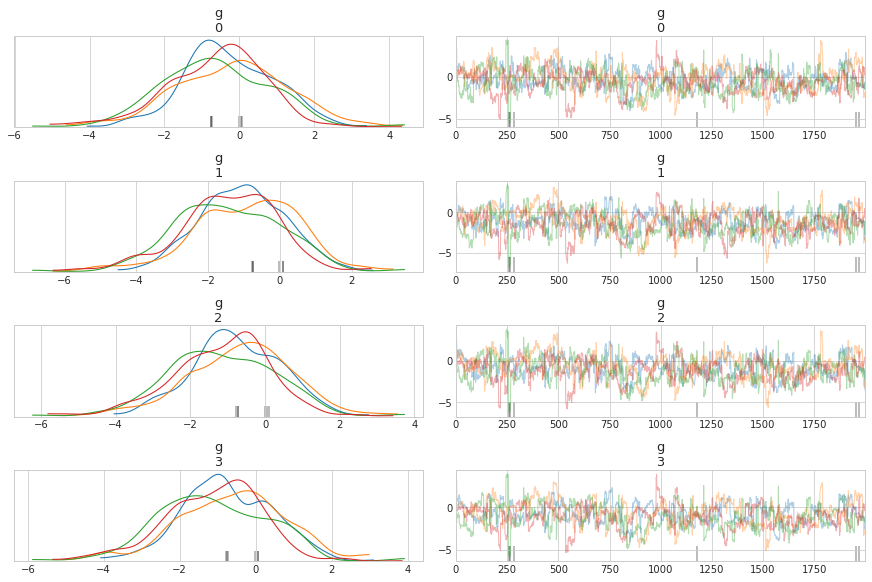

In [49]:
az.plot_trace(az_d2_m3, var_names=['g'])
plt.show()

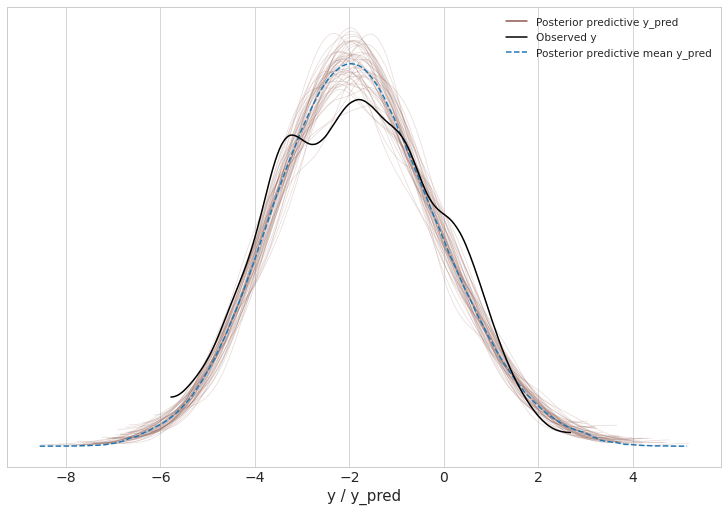

In [50]:
az.plot_ppc(az_d2_m3, data_pairs={'y':'y_pred'}, num_pp_samples=50)
plt.show()

In [51]:
fit3_summary = az.summary(az_d2_m3)

In [52]:
fit3_alpha_summary = fit3_summary[fit3_summary.index.str.contains('alpha\[')]
shrna_idx = [re.search(r"\[([A-Za-z0-9_]+)\]", a).group(1) for a in fit3_alpha_summary.index]
shrna_idx = [int(a) + 1 for a in shrna_idx]
fit3_alpha_summary = fit3_alpha_summary \
    .assign(barcode_sequence_idx = shrna_idx) \
    .set_index('barcode_sequence_idx') \
    .join(modeling_data[['barcode_sequence_idx', 'gene_symbol']] \
          .drop_duplicates() \
          .set_index('barcode_sequence_idx'))
fit3_alpha_summary.head(10)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,gene_symbol
barcode_sequence_idx,,,,,,,,,,,,
1,1.649,1.368,-0.849,4.215,0.096,0.068,205.0,205.0,204.0,382.0,1.02,EIF6
2,0.157,1.367,-2.392,2.688,0.095,0.067,206.0,206.0,205.0,369.0,1.02,EIF6
3,-1.037,1.404,-3.631,1.576,0.093,0.066,230.0,227.0,229.0,362.0,1.02,COL8A1
4,-0.593,1.358,-3.099,1.927,0.095,0.067,205.0,205.0,204.0,358.0,1.02,KRAS
5,-1.437,1.359,-3.945,1.081,0.095,0.067,205.0,205.0,205.0,347.0,1.02,KRAS
6,0.542,1.389,-1.987,3.220,0.097,0.069,204.0,204.0,203.0,331.0,1.02,COG3
7,-0.695,1.391,-3.292,1.852,0.097,0.069,205.0,205.0,204.0,323.0,1.02,COG3
8,-1.708,1.357,-4.227,0.846,0.095,0.068,202.0,202.0,201.0,343.0,1.02,KRAS
9,0.701,1.358,-1.861,3.227,0.095,0.067,206.0,206.0,205.0,351.0,1.02,KRAS


In [53]:
fit3_gene_summary = fit3_summary[fit3_summary.index.str.contains('g\[')]
gene_idx = [re.search(r"\[([A-Za-z0-9_]+)\]", a).group(1) for a in fit3_gene_summary.index]
gene_idx = [int(a) + 1 for a in gene_idx]
fit3_gene_summary = fit3_gene_summary \
    .assign(gene_symbol_idx = gene_idx) \
    .set_index('gene_symbol_idx') \
    .join(modeling_data[['gene_symbol_idx', 'gene_symbol']] \
          .drop_duplicates() \
          .set_index('gene_symbol_idx')) \
    .reset_index(drop=False)
fit3_gene_summary.head(10)

,gene_symbol_idx,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,gene_symbol
0,1,-0.453,1.376,-3.146,1.990,0.097,0.069,201.0,201.0,200.0,315.0,1.02,COG3
1,2,-1.236,1.399,-3.987,1.198,0.093,0.066,227.0,227.0,225.0,365.0,1.02,COL8A1
2,3,-0.963,1.355,-3.530,1.495,0.095,0.067,203.0,203.0,201.0,350.0,1.02,EIF6
3,4,-0.922,1.345,-3.294,1.665,0.095,0.067,200.0,200.0,199.0,341.0,1.03,KRAS


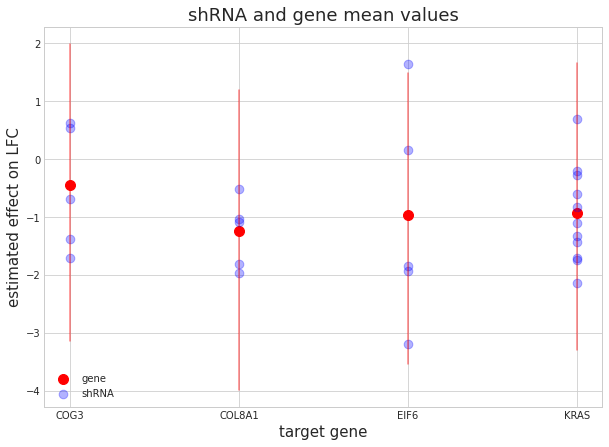

In [54]:
for i in range(fit3_gene_summary.shape[0]):
    plt.plot(np.repeat(fit3_gene_summary.loc[i, 'gene_symbol'], 2), 
             [fit3_gene_summary.loc[i, 'hpd_3%'], fit3_gene_summary.loc[i, 'hpd_97%']],
             color='red', alpha=0.5)


plt.scatter(fit3_gene_summary['gene_symbol'], 
            fit3_gene_summary['mean'],
            s=100, c='r', label='gene')
plt.scatter(fit3_alpha_summary['gene_symbol'], 
            fit3_alpha_summary['mean'], 
            alpha=0.3, s=75, c='b', label='shRNA')

plt.title('shRNA and gene mean values')
plt.xlabel('target gene')
plt.ylabel('estimated effect on LFC')
plt.legend()
plt.show()

## Model 4. Parameters for difference between average gene effect and cell line-specific effect

Note that the varying intercept for shRNA has been renamed from $\alpha$ to $c$.
$\bar g_{l}$ is the average effect of knocking-down gene $l$ while $g_{jl}$ is the cell line $j$-specific effect of knocking-down $l$.

$$
D_{i|s} \sim N(\mu_{i|s}, \sigma) \\
\mu = c_{i|s} + \bar g_{i|l} - g_{i|jl} \\
c_s \sim N(0, \sigma_c) \\
\bar g_l \sim N(\mu_{\bar g}, \sigma_{\bar g}) \\
g_{jl} \sim N(0, \sigma_g) \\
\sigma_c \sim \text{HalfCauchy}(0, 3) \\
\mu_{\bar g} \sim N(0, 2) \quad \sigma_{\bar g} \sim \text{HalfCauchy}(0, 10) \\
\sigma_g \sim \text{HalfCauchy}(0, 5) \\
\sigma \sim \text{HalfCauchy}(0, 10)
$$

In [55]:
d2_m4_data = {
    'N': int(modeling_data.shape[0]),
    'S': np.max(modeling_data.barcode_sequence_idx),
    'L': np.max(modeling_data.gene_symbol_idx),
    'J': np.max(modeling_data.cell_line_idx),
    
    'shrna': modeling_data.barcode_sequence_idx,
    'gene': modeling_data.gene_symbol_idx,
    'cell_line': modeling_data.cell_line_idx,
    
    'y': modeling_data.lfc,
}

**Compile model.**

In [56]:
start = timer()
d2_m4_file = models_dir / 'd2_m4.cpp'
d2_m4 = pystan.StanModel(file=d2_m4_file.as_posix())
end = timer()
print(f'{(end - start) / 60:.2f} minutes to compile model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fab05e14f81a486812ff3fbe526c78c0 NOW.


0.74 minutes to compile model


In [57]:
d2_m4_control = {'adapt_delta': 0.999, 
                 'max_treedepth': 20}
d2_m4_fit = d2_m4.sampling(data=d2_m4_data, 
                           iter=3000, warmup=1000, chains=4, 
                           control=d2_m4_control)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [58]:
pystan.check_hmc_diagnostics(d2_m4_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': False,
 'treedepth': True,
 'energy': True}

In [59]:
az_d2_m4 = az.from_pystan(posterior=d2_m4_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m4)
az.summary(az_d2_m4).head()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma_c,1.202,0.192,0.860,1.562,0.002,0.002,8617.0,7747.0,9899.0,5735.0,1.0
mu_gbar,-1.708,0.573,-2.777,-0.654,0.010,0.007,3012.0,3012.0,3135.0,3148.0,1.0
sigma_gbar,0.831,0.841,0.010,2.220,0.021,0.015,1610.0,1610.0,1187.0,1619.0,1.0
sigma_g,0.534,0.058,0.420,0.636,0.001,0.001,3501.0,3501.0,3470.0,4471.0,1.0
c[0],2.612,0.463,1.736,3.486,0.010,0.007,2157.0,2157.0,2164.0,3143.0,1.0


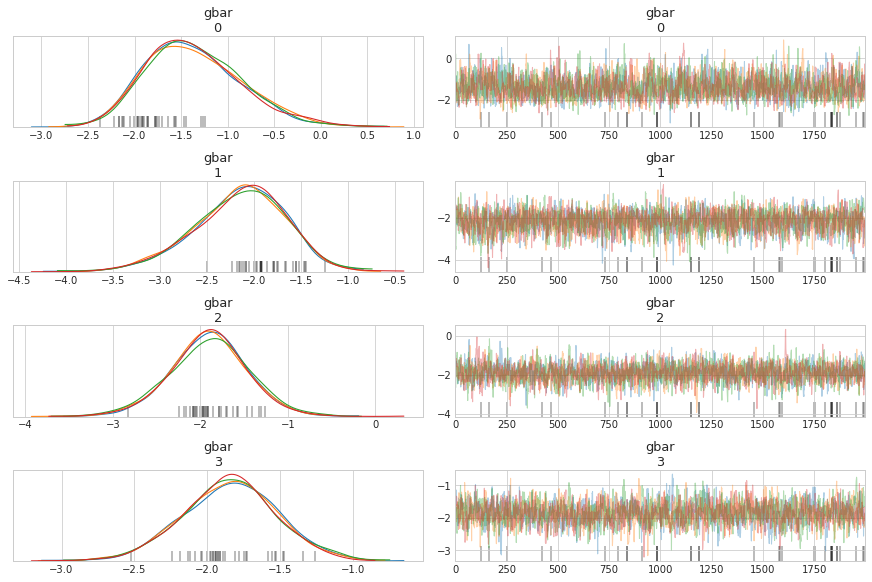

In [60]:
az.plot_trace(az_d2_m4, var_names=['gbar'])
plt.show()

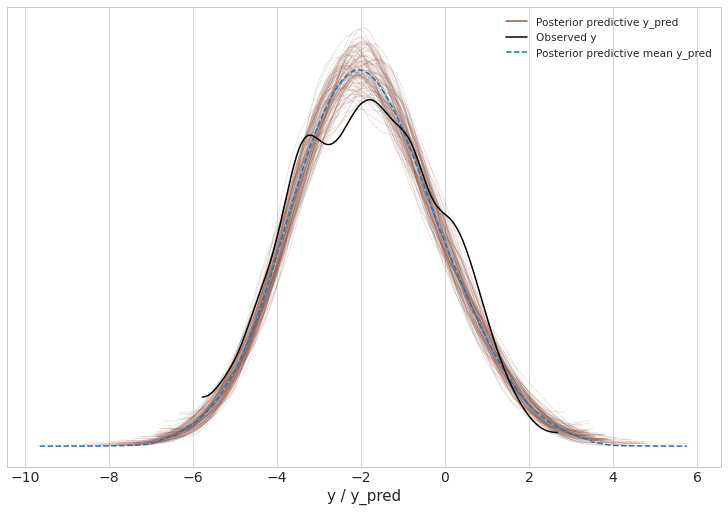

In [61]:
az.plot_ppc(az_d2_m4, data_pairs={'y':'y_pred'}, num_pp_samples=100)
plt.show()

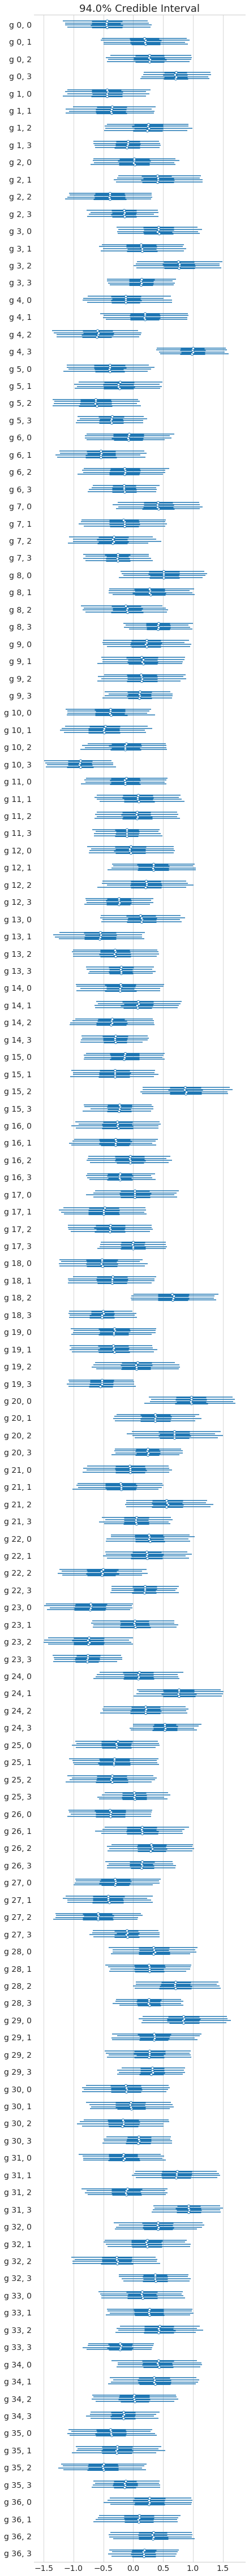

In [62]:
az.plot_forest(az_d2_m4, var_names='g')
plt.show()

**To-Do:** 

- show $g_{jl}$ for each gene
- show distribution of intercepts for shRNA $c_s$
- show distribution of values for cell lines